In [14]:
using DataFrames
using PythonPlot
using Statistics
using CSV
using JLD2

In [7]:
# read in retrocue_E1_clean.csv
data = CSV.read("retrocue_E1_clean.csv", DataFrame)
first(data,6)

Row,Column1,Subject,trial.number,Observation.id,food.loc,distract.loc,n_searches,delay,load,baiting,interval,first.search.time,first.search.loc,time.to.search,first.search,food.loc.row,food.loc.col,first.search.row,first.search.col
,Int64,String7,Int64,String31,String3,String7,Int64,String1,Int64,Float64,Float64,Float64,String3,Float64,Int64,String1,Int64,String1,Int64
1,1,Alba,1,Alba_E1_S1_T1,C2,None,1,M,1,35.24,10.88,47.64,C2,12.4,1,C,2,C,2
2,2,Alba,10,Alba_E1_S2_T3-4,E1,B1,2,L,2,92.12,10.96,104.48,E3,12.36,0,E,1,E,3
3,3,Alba,11,Alba_E1_S2_T5-6,B3,E2,3,M,2,53.32,10.32,66.24,B1,12.92,0,B,3,B,1
4,4,Alba,12,Alba_E1_S2_T5-6,F1,C2,1,S,2,112.64,7.12,125.04,F1,12.4,1,F,1,F,1
5,5,Alba,13,Alba_E1_S3_T1-6,D2,None,2,M,1,21.72,8.04,32.4,D3,10.68,0,D,2,D,3
6,6,Alba,14,Alba_E1_S3_T1-6,F1,None,3,S,1,66.84,6.76,75.56,F3,8.72,0,F,1,F,3


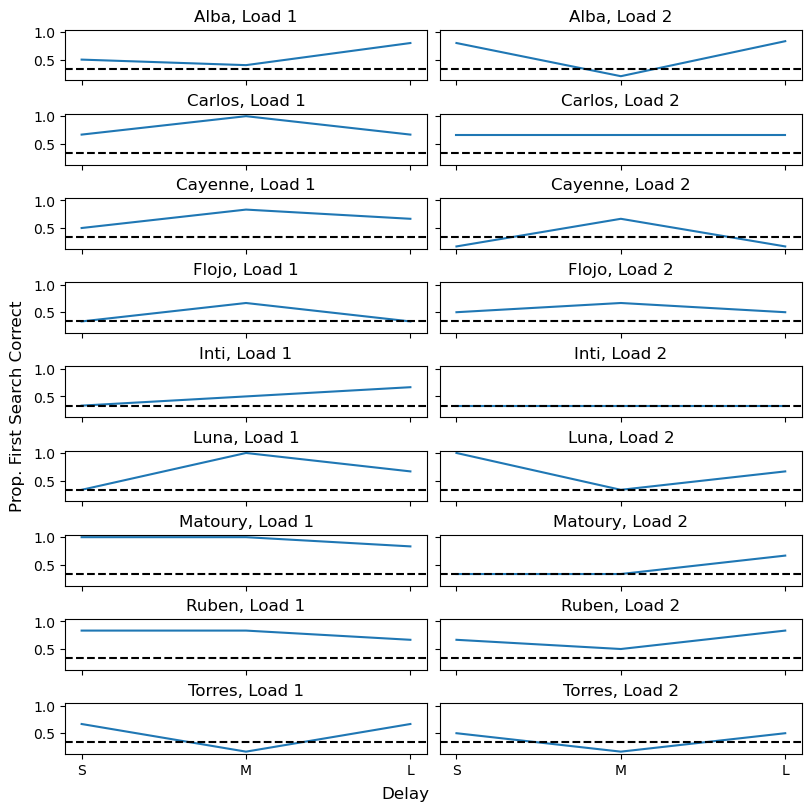

Python: Text(0.5, 0.00520875, 'Delay')

In [8]:

nsubj = length(unique(data[!,:Subject])) # 9 subjects
grouped_df = combine(groupby(data, [:delay, :load, :Subject]), Symbol("first.search") => mean => :mean_n_searches)

using CategoricalArrays

# Ensure the delay column is a categorical variable with specified order
grouped_df.delay = categorical(grouped_df.delay, levels=["S", "M", "L"], ordered=true)


subjects = unique(grouped_df.Subject)
delays = ["S", "M", "L"]
N_delays = length(delays)
loads = [1, 2]
N_loads = length(loads)
colors = Dict(subjects .=> range(0, stop=1, length=length(subjects)))  # Different color for each subject
markers = Dict(1 => "o", 2 => "s")  # Different markers for each load

fig,ax = subplots(nsubj, N_loads, sharey = true, sharex = true, figsize=(8, 8), constrained_layout=true)

subj = subjects[1]

for (s_idx, subj) in enumerate(subjects)
    subj_data = grouped_df[grouped_df.Subject .== subj, :]

    for i in 1:N_loads
        # i = 1
        load = loads[i]
        load_data = subj_data[subj_data.load .== load, :]

        # Sort the load_data dataframe based on delay order
        load_data = sort(load_data, :delay)

        load_delays = convert(Vector{String}, string.(load_data.delay))
        ax[s_idx-1, i-1].plot(load_delays, load_data.mean_n_searches)
        ax[s_idx-1, i-1].set_title("$subj, Load $load")

        # plot a dashed horzontal line at .3333
        ax[s_idx-1, i-1].axhline(y=1/3, color="black", linestyle="--")
    end
end
fig.supylabel("Prop. First Search Correct")
fig.supxlabel("Delay")


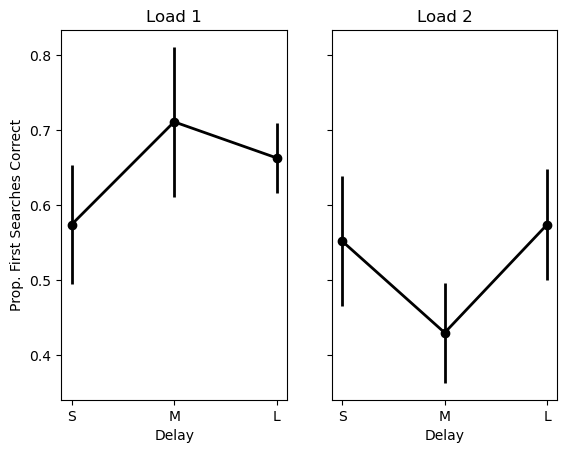

Python: Text(24.000000000000014, 0.5, 'Prop. First Searches Correct')

In [9]:
# take the mean of grouped_df accross subjects
mean_grouped_df = combine(groupby(grouped_df, [:delay, :load]), :mean_n_searches => mean => :mean_n_searches)
# also compute the standard error of the mean
sem(x) = std(x) / sqrt(length(x))
sem_grouped_df = combine(groupby(grouped_df, [:delay, :load]), :mean_n_searches => sem => :sem_n_searches)

fig,ax = subplots(1, N_loads, sharey = true)

for i in 1:N_loads
    load = loads[i]
    load_data = mean_grouped_df[mean_grouped_df.load .== load, :]

    load_delays = convert(Vector{String}, string.(load_data.delay))

    # plot mean with error bars for sem
    ax[i-1].errorbar(load_delays, load_data.mean_n_searches, yerr=sem_grouped_df[sem_grouped_df.load .== load, :sem_n_searches], fmt="-o", color="black", linewidth=2)

    # ax[i-1].plot(load_delays, load_data.mean_n_searches, "-o", color="black", linewidth=2)
    ax[i-1].set_title("Load $load")
    ax[i-1].set_xlabel("Delay")
end
ax[0].set_ylabel("Prop. First Searches Correct")



In [ ]:
mean_grouped_df

# structure this in the same way that the simulations are saved...

Row,delay,load,mean_n_searches
,Cat…,Int64,Float64
1,S,1,0.574074
2,S,2,0.551852
3,M,1,0.711111
4,M,2,0.42963
5,L,1,0.662963
6,L,2,0.574074


In [ ]:
# load the results for each parameter combination run...
# list all conditions we want to run
N_Object_Vals = [2, 3]; # this is just 2 and 3, but in practice, it is 1 and 2
N_Seconds_NoCue = [5,7,10]

# parameter values...
NT_vals = [50,100,200,400]#[800]#[25, 50, 100, 200, 400, 800]
# set parameters for each job... 
eps_vals = collect(1:-.02:.01) # 17

# quanta values - could be more fine-grained...
q_vals = collect(2:4:100) #

# memory slopes
mem_slopes = [.05, .1, .2, .4]

4-element Vector{Float64}:
 0.05
 0.1
 0.2
 0.4

In [ ]:
# Create list of all parameter combinations
function create_parameter_list(eps_vals, q_vals, NT_vals, mem_slopes)
    all_params = []
    
    for epsilon in eps_vals
        for N_Quanta in q_vals
            for NT_per_Second in NT_vals
                for mem_slope in mem_slopes
                    push!(all_params, Dict(
                        "epsilon" => epsilon,
                        "N_Quanta" => Int(N_Quanta),
                        "NT_per_Second" => Int(NT_per_Second),
                        "mem_slope" => mem_slope
                    ))
                end
            end
        end
    end
    
    return all_params
end


function load_results(N_Quanta, epsilon, NT_per_Second; res_part = "delayed_memory")

    # res_part should either be "delayed_memory" or "retrocue"

    res_folder = "/Users/erussek/Dropbox/Griffiths_Lab_Stuff/Data/Memory_Models/monkey_sims"
    
    file_name = "N_Quanta_$(N_Quanta)_epsilon_$(epsilon)_NT_$(NT_per_Second).jld2"

    full_file_path = joinpath(res_folder, res_part, file_name)

    results = load(full_file_path)
    
    return results

end


# function to load delay_prob_correct and retro_cue_prob_correct
function load_prob_correct(N_Quanta, epsilon, NT_per_Second)

    # load delayed memory results
    these_res = load_results(N_Quanta, epsilon, NT_per_Second, res_part = "delayed_memory")

    # N_Obj X N_Sec, N_Memslopes - delay_prob_correct
    delay_prob_correct = these_res["delay_prob_correct"]

    return delay_prob_correct

end

# Function to load a single data point and turn it into a feature and target vector
function load_data_point(params)
    delay_prob = load_prob_correct(
        params["N_Quanta"],
        params["epsilon"],
        params["NT_per_Second"]
    )

    mem_slopes = [.05, .1, .2, .4]
    mem_slope_idx = findfirst(x -> isapprox(x, params["mem_slope"], rtol=1e-10), mem_slopes)
    
    if isnothing(mem_slope_idx)
        error("Invalid mem_slope value: $(params["mem_slope"])")
    end
    
    # Extract and flatten features
    delay_features = vec(delay_prob[:, :, mem_slope_idx])
    
    return delay_features, targets
end



load_prob_correct (generic function with 1 method)

In [23]:
# load results for first value of each parameter
res = load_results(q_vals[1], eps_vals[1], NT_vals[1])    
res["delay_prob_correct"]

2×3×4 Array{Float64, 3}:
[:, :, 1] =
 0.525218  0.525218  0.525218
 0.515749  0.515749  0.515749

[:, :, 2] =
 0.548036  0.548036  0.548036
 0.53      0.53      0.53

[:, :, 3] =
 0.587365  0.587365  0.587365
 0.554562  0.554562  0.554562

[:, :, 4] =
 0.645928  0.645928  0.645928
 0.591136  0.591136  0.591136

In [27]:
param_list = create_parameter_list(eps_vals, q_vals, NT_vals, mem_slopes)
param_df = DataFrame(param_list)

Row,NT_per_Second,N_Quanta,epsilon,mem_slope
,Int64,Int64,Float64,Float64
1,50,2,1.0,0.05
2,50,2,1.0,0.1
3,50,2,1.0,0.2
4,50,2,1.0,0.4
5,100,2,1.0,0.05
6,100,2,1.0,0.1
7,100,2,1.0,0.2
8,100,2,1.0,0.4
9,200,2,1.0,0.05
